In [8]:
import mediapipe as mp
import cv2
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.misc import derivative
from scipy.signal import find_peaks
from statistics import stdev,mean
import itertools as itr
import pprint, pickle
from scipy.interpolate import UnivariateSpline



# definitions

In [9]:
def time_diff(peaks):
    array=[]
    for i in range(len(peaks)-1):
        td=df.t[peaks[i+1]]-df.t[peaks[i]]
        array.append(td)
    return array

def get_peaks(df,y):
    peaks, _ = find_peaks(-y,prominence=0.03)
    plt.figure(figsize=(20,5))
    plt.plot(df.t,y)
    plt.plot(df.t[peaks], y[peaks],"X",markerfacecolor='red',markersize=8)
    plt.show()
    return peaks

def distribution(data):
    ax=sns.distplot(data,
                kde=True,
                bins=8,
                color='blue',
                hist_kws={"linewidth": 22,'alpha':0.60})
    ax.set(xlabel='Binomial',ylabel='Frequency')
    plt.show()
    
def remove_time_gap(data):
    from statistics import stdev,mean
    SD=stdev(data)
    m= mean(data)
 
    cut_off = SD * 0.5
    upper =  m + cut_off
    array = [x for x in data if x < upper]
    return array
    
    
def remove_distinc(array,df,Time_to_index_ratio,y):
    modified_mean= mean(array)
    Distance=Time_to_index_ratio*modified_mean*0.5
    
    peaks, _ = find_peaks(-y,prominence=0.03,distance=Distance)
    plt.figure(figsize=(20,5))
    plt.plot(df.t,y)
    plt.plot(df.t[peaks], y[peaks],"X",markerfacecolor='red',markersize=8)
    plt.show()
    return peaks
    
    
def sample(df,strike_peak,time_return_points):
    a = np.array(df.t[strike_peak])
    sample_strikes=[]
    for i in range(len(time_return_points)-1):
        index=np.where(np.logical_and(a>=time_return_points.t[i], a<=time_return_points.t[i+1]))
        s = list(map(lambda a : df.t[strike_peak[a]], index[0]))
        sample_strikes.append(s)
    return sample_strikes


def strides(sample_strikes):
    strides=[]
    for strike in sample_strikes:
        sample=[]
        for i in range(len(strike)-1):
            t_diff=strike[i+1]-strike[i]
            sample.append(t_diff)
        strides.append(sample)
    return strides
    
    
def com(A,B):
    if type(A)==np.ndarray:
        C= A.tolist()
    else:
        C=A
    for i,v in enumerate(B):
        C.insert(2*i+1,v) 
    return C

def step_time(right,left):
    L_array=[]
    R_array=[]
    try:
        if len(right)==len(left):
            if left[0]>right[0]:
                #print(1)
                Lstep=np.subtract(left,right) 
                L_array=Lstep
                Rstep=np.subtract(right[1:],left[:-1]) 
                R_array=Rstep
            else:
                #print(2)
                Rstep=np.subtract(right,left)
                R_array=Rstep
                Lstep=np.subtract(left[1:],right[:-1]) 
                L_array=Lstep

        elif (len(right)+1)==len(left):#when left strides are max by one
            if right[0]>left[0]:
                #print(3)
                Lstep=np.subtract(left[1:],right) 
                L_array=Lstep
                Rstep=np.subtract(right,left[:-1]) 
                R_array=Rstep

        elif len(right)==(len(left)+1):#when right strides are max by one
            if left[0]>right[0]:
                #print(4)
                Lstep=np.subtract(left,right[:-1]) 
                L_array=Lstep
                Rstep=np.subtract(right[1:],left) 
                R_array=Rstep

        else:
            #print(5)
            L_array.append('ooa')
            R_array.append('ooa')
    except:
        L_array.append('ooa')
        R_array.append('ooa')
        
    return R_array,L_array

def step_time_array(sample_strikes_R,sample_strikes_L):
    R_st_array=[]
    L_st_array=[]
    for i in range(len(sample_strikes_R)):
        if not len(sample_strikes_R[i])==0:
            Rst,Lst=step_time(sample_strikes_R[i],sample_strikes_L[i])
            R_st_array.append(Rst)
            L_st_array.append(Lst)
    return R_st_array,L_st_array

def comb_dir_arrays(plus_array,minus_array,plus,minus):   
    if plus<minus:
        array=com(plus_array,minus_array)
    elif plus>minus:
        array=com(minus_array,plus_array)
    return array

def time_diff_array(first,second):
    second_array=[]
    first_array=[]
    try:
        if len(first)==len(second):
            if second[0]>first[0]:
                #print(1)
                Lstep=np.subtract(second,first) 
                second_array=Lstep
                Rstep=np.subtract(first[1:],second[:-1]) 
                first_array=Rstep
            else:
                #print(2)
                Rstep=np.subtract(first,second)
                first_array=Rstep
                Lstep=np.subtract(second[1:],first[:-1]) 
                second_array=Lstep

        elif (len(first)+1)==len(second):#when left strides are max by one
            if first[0]>second[0]:
                #print(3)
                Lstep=np.subtract(second[1:],first) 
                second_array=Lstep
                Rstep=np.subtract(first,second[:-1]) 
                first_array=Rstep

        elif len(first)==(len(second)+1):#when right strides are max by one
            if second[0]>first[0]:
                #print(4)
                Lstep=np.subtract(second,first[:-1]) 
                second_array=Lstep
                Rstep=np.subtract(first[1:],second) 
                first_array=Rstep

        else:
            #print(5)
            second_array.append('ooa')
            first_array.append('ooa')
            
    except:
            second_array.append('ooa')
            first_array.append('ooa')
        


    return first_array,second_array

def swing_array(sample_strikes_hs,sample_strikes_to):
    swing_array=[]
    for i in range(len(sample_strikes_hs)):
        if not len(sample_strikes_hs[i])==0:
            #print(len(sample_strikes_plus_R[i]),len(sample_strikes_plus_L[i]))
            hs_to,_=time_diff_array(sample_strikes_hs[i],sample_strikes_to[i])
            swing_array.append(hs_to)
    return swing_array
        
    
def avrg(x):
    array=[]
    for i in x:
        if i==['ooa']:
            array.append(['ooa'])
        elif len(i)==0:
            array.append([])
        else:
            s=0
            for j in i:
                s+=j
            m=s/len(i)
            array.append(m)    
    return array

def double_support_time(to_R,hs_R,to_L,hs_L):
    array=[]
    if to_R==hs_L==hs_R==hs_L:
        if to_R[0]>hs_L[i][0]:
            dst1=np.subtract(to_R,hs_L)
            dst2=np.subtract(to_L[1:],hs_R)
            dst=np.add(dst1,dst2)
            array.append(dst)
        elif to_L[i][0]>hs_R[i][0]:
            dst1=np.subtract(to_R[1:],hs_L)
            dst2=np.subtract(to_L,hs_R)
            dst=np.add(dst1,dst2)
            array.append(dst)
        else:
            dst_array.append("ooa")
        return array
    else:
        return "ooa"  
    
def double_support_time_array(sample_strikes_to_R,sample_strikes_hs_R,sample_strikes_to_L,sample_strikes_hs_L):
    dst_array=[]
    for i in range(min(len(sample_strikes_to_R),len(sample_strikes_to_L))):
        if not len(sample_strikes_to_R[i])==0:
            array=double_support_time(sample_strikes_to_R[i],sample_strikes_hs_R[i],sample_strikes_to_L[i],sample_strikes_hs_L[i])
            dst_array.append(array)
    return dst_array
        
def stance_time_ratio_array(sample_strikes_to_R,sample_strikes_hs_R,sample_strikes_to_L,sample_strikes_hs_L,T):
    str_array=[]
    for i in range(min(len(sample_strikes_to_R),len(sample_strikes_to_L))):
        if not (len(sample_strikes_to_R[i])==0 or len(sample_strikes_to_L[i])==0 or len(sample_strikes_hs_R[i])==0 or len(sample_strikes_hs_L[i])==0):
            left,_=time_diff_array(sample_strikes_to_L[i][1:],sample_strikes_hs_L[i][:-1])
            right,_=time_diff_array(sample_strikes_to_R[i][1:],sample_strikes_hs_R[i][:-1])
            if left==['ooa'] or right==['ooa']:
                str_array.append(['ooa'])
            else:
                if len(left)>len(right):
                    right=np.concatenate((right, [np.mean(right)]*abs(len(left)-len(right))), axis=0)
                elif len(left)<len(right):
                    left=np.concatenate((left, [np.mean(left)]*abs(len(left)-len(right))), axis=0)
                array=np.add(left,right)
                print(array)
                array=array/T[i]
                str_array.append(array)

    return str_array

def swing_time_ratio_array(sample_strikes_to_R,sample_strikes_hs_R,sample_strikes_to_L,sample_strikes_hs_L,T):
    swr_array=[]
    for i in range(min(len(sample_strikes_to_R),len(sample_strikes_to_L))):
        if not len(sample_strikes_to_R[i])==0:
            left,_=time_diff_array(sample_strikes_hs_L[i],sample_strikes_to_L[i])
            right,_=time_diff_array(sample_strikes_hs_R[i],sample_strikes_to_R[i])
            if left==['ooa'] or right==['ooa']:
                swr_array.append(['ooa'])
            else:
                if len(left)>len(right):
                    right=np.concatenate((right, [np.mean(right)]*abs(len(left)-len(right))), axis=0)
                elif len(left)<len(right):
                    left=np.concatenate((left, [np.mean(left)]*abs(len(left)-len(right))), axis=0)
                array=np.add(left,right)
                array=array/T[i]
                swr_array.append(array)
            
    return swr_array

def extract_strike_times(df,Time_to_index_ratio):
    peaks=get_peaks(df,df.r)


    dt=time_diff(peaks)
    print(dt)
    distribution(dt)


    dt_new=remove_time_gap(dt)
    distribution(dt_new)

    peaks_new=remove_distinc(dt_new,df,Time_to_index_ratio,df.r)

    dt=time_diff(peaks_new)
    dt_cleaned=remove_time_gap(dt)
    distribution(dt_cleaned)
    
    return dt_cleaned,peaks_new

def sample_and_avg(df_plus,df_minus,plus_peaks,minus_peaks,time_return_points):
    sample_strikes_plus=sample(df_plus,plus_peaks,time_return_points)
    sample_strikes_minus=sample(df_minus,minus_peaks,time_return_points)
    
    strides_plus=strides(sample_strikes_plus)
    strides_minus=strides(sample_strikes_minus)
    print('strides')
    print(strides_plus)
    print('\n')
    print(strides_minus)

    avg_stride_plus=list(map(lambda a : np.mean(a), strides_plus[plus::2]))
    avg_stride_minus=list(map(lambda a : np.mean(a), strides_minus[minus::2]))
    print('Avg strides')
    print(avg_stride_plus)
    print('\n')
    print(avg_stride_minus)
    
    return sample_strikes_plus,sample_strikes_minus,avg_stride_plus,avg_stride_minus


def extract_steps(sample_strikes_R,sample_strikes_L,peaks_R,peaks_L,df):
    plt.figure(figsize=(20,5))
    plt.plot(df.t,df.l,'b')
    plt.plot(df.t,df.r,'r')
    plt.plot(df.t[peaks_L], df.l[peaks_L],"X",markerfacecolor='red',markersize=8)
    plt.plot(df.t[peaks_R], df.r[peaks_R],"X",markerfacecolor='black',markersize=8)
    plt.show()

    print(sample_strikes_L)
    print(sample_strikes_R)

    sample_strikes_L = sample_strikes_L[plus::2]
    sample_strikes_R = sample_strikes_R[plus::2]

    step_R,_=step_time_array(sample_strikes_plus_R,sample_strikes_plus_L)
    step_L,_=step_time_array(sample_strikes_plus_L,sample_strikes_plus_R)

    print(step_R)
    print(step_L)
    
    return step_R,step_L
    
def outlier_remove(h_valley_R,f_valley_R,df):
    #toe off
    dt_to_r=time_diff(h_valley_R)
    distribution(dt_to_r)
    dt_to_r_new=remove_time_gap(dt_to_r)
    distribution(dt_to_r_new)
    peaks_to_r=remove_distinc(dt_to_r,df,Time_to_index_ratio,df.h_R)
    dt_to_r=time_diff(peaks_to_r)
    dt_to_r_cleaned=remove_time_gap(dt_to_r)
    distribution(dt_to_r_cleaned)
    
    #heel strike
    dt_hs_r=time_diff(f_valley_R)
    distribution(dt_hs_r)
    dt_hs_r_new=remove_time_gap(dt_hs_r)
    distribution(dt_hs_r_new)
    peaks_hs_r=remove_distinc(dt_hs_r,df,Time_to_index_ratio,df.f_R)
    dt_hs_r=time_diff(peaks_hs_r)
    dt_hs_r_cleaned=remove_time_gap(dt_hs_r)
    distribution(dt_hs_r_cleaned)
    
    return dt_to_r_cleaned,dt_hs_r_cleaned,peaks_to_r,peaks_hs_r

names=['amani','gayanjali','harshi','hasitha','isurika','gihan','jayasanka','chathura','geemanthi','damith']

In [10]:
name='evidence'

In [13]:
index=0

name=names[index]

In [14]:


f_file = open('key_arrays/left/key_array_{}_left.pkl'.format(name), 'rb')

key_array = pickle.load(f_file)
#pprint.pprint(fT)

f_file.close()

# anckle-hip length side

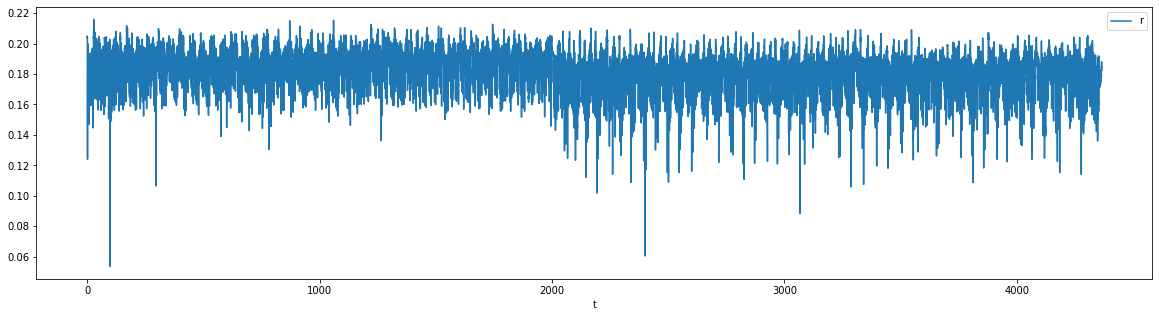

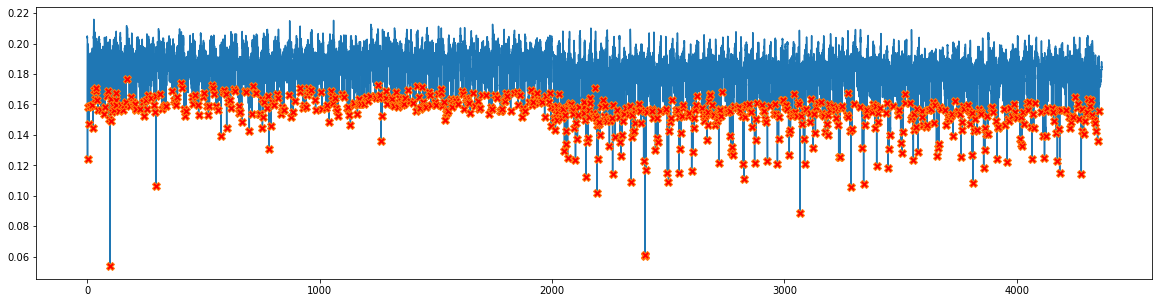

In [15]:
array=[]
for i in range(len(key_array)):
    t=key_array[i][28][3]
    right=abs(key_array[i][24][1]-key_array[i][28][1])
    left=abs(key_array[i][23][1]-key_array[i][27][1])
    heel_r=abs(key_array[i][24][1]-key_array[i][30][1])
    foot_index_r=abs(key_array[i][24][1]-key_array[i][32][1])
    heel_l=abs(key_array[i][23][1]-key_array[i][29][1])
    foot_index_l=abs(key_array[i][23][1]-key_array[i][31][1])
    x=key_array[i][28][0]
    center=(key_array[i][11][0]+key_array[i][12][0]+key_array[i][23][0]+key_array[i][24][0])/4
    array.append([right])
    array[i].append(left)
    array[i].append(heel_r)
    array[i].append(foot_index_r)
    array[i].append(heel_l)
    array[i].append(foot_index_l)
    array[i].append(t)
    array[i].append(x)
    array[i].append(center)
array = np.array(array)
#print(array)

df = pd.DataFrame(array,columns=['r','l','h_R','f_R','h_L','f_L','t','x','center'])


df.plot(x ='t', y='r', kind = 'line',figsize=(20,5))
plt.show()

peaks=get_peaks(df,df.r)

Time_to_index_ratio=(peaks[1]-peaks[0])/(df.t[peaks[1]]-df.t[peaks[0]])

# walking direction

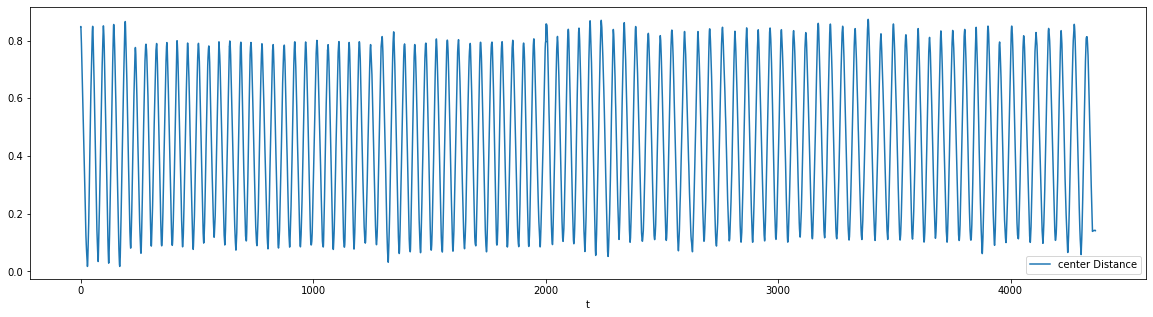

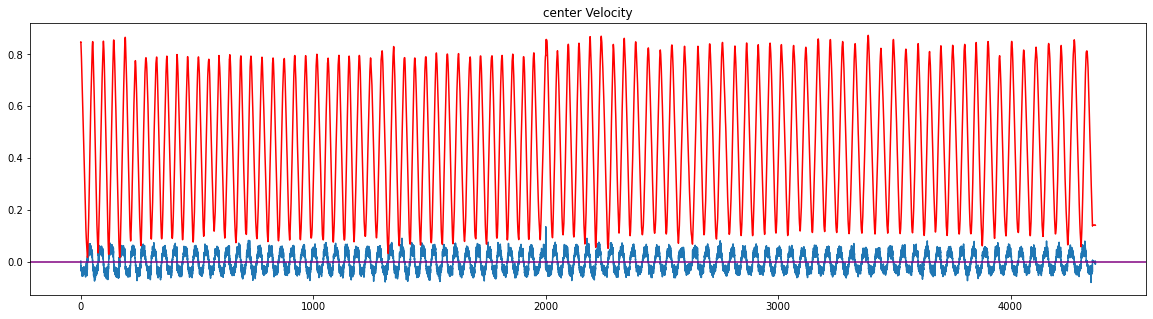

[252, 470, 676, 879, 1085, 1294, 1526, 1734, 1940, 2131, 2341, 2549, 2753, 2966, 3162, 3379, 3582, 3775, 3989, 4187, 4391, 4593, 4794, 4989, 5195, 5387, 5604, 5803, 6033, 6230, 6434, 6617, 6844, 7039, 7264, 7456, 7657, 7875, 8075, 8278, 8480, 8683, 8897, 9120, 9359, 9543, 9741, 9965, 10170, 10357, 10543, 10749, 10974, 11195, 11413, 11635, 11867, 12079, 12289, 12502, 12715, 12897, 13115, 13327, 13531, 13737, 13962, 14158, 14368, 14597, 14819, 15047, 15264, 15452, 15672, 15891, 16078, 16279, 16474, 16690, 16911, 17101, 17300, 17506, 17725, 17956, 18176, 18365, 18565, 18774, 18979, 19187, 19400, 19605, 19808, 20019, 20262, 20469, 20675, 20884, 21090, 21304, 21539, 21762, 21973, 22187, 22393, 22612, 22845, 23087, 23362, 23590, 23801, 24016, 24253, 24492, 24731, 24948, 25165, 25379, 25589, 25807, 26037, 26255, 26462, 26671, 26892, 27124, 27348, 27566, 27790, 28012, 28236, 28455, 28675, 28902, 29124, 29362, 29598, 29837, 30073, 30301, 30532, 30753, 30984, 31203, 31412, 31629, 31834, 32050, 3

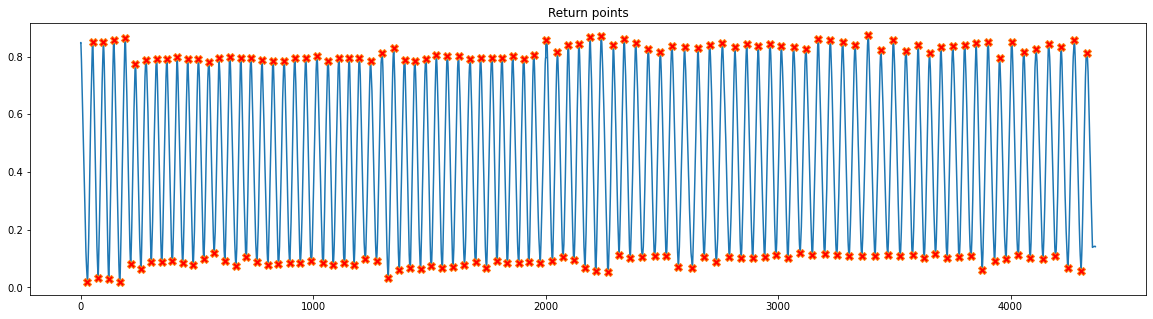

[    1   242   243   249   250   251   252   253   255   256   469   676
   712   713   877   878   879  1084  1293  1493  1494  1520  1521  1522
  1524  1526  1731  1732  1734  1940  2131  2337  2338  2340  2548  2752
  2966  3161  3375  3376  3378  3574  3575  3577  3578  3582  3768  3769
  3775  3776  3777  3778  3779  3984  3985  3988  4184  4185  4186  4389
  4390  4391  4593  4790  4791  4793  4988  5192  5193  5194  5386  5604
  5605  5607  5783  5784  5788  5789  5802  5806  5808  6032  6228  6229
  6230  6434  6599  6600  6616  6844  7038  7042  7043  7263  7264  7265
  7438  7439  7456  7457  7458  7656  7852  7853  7874  8075  8267  8268
  8272  8273  8276  8277  8278  8479  8682  8891  8892  8893  8894  8896
  8899  8901  9120  9121  9123  9124  9126  9139  9140  9359  9519  9520
  9522  9523  9537  9538  9542  9740  9744  9745  9965 10169 10356 10543
 10749 10973 10974 10975 10977 10978 10980 10981 10983 10984 11190 11191
 11194 11410 11411 11414 11634 11863 11864 11866 12

In [16]:
df.plot(label='center Distance', x ='t', y='center', kind = 'line',figsize=(20,5))
plt.show()



spl = UnivariateSpline(df.t, df.center, k=4, s=0)
diffspl = spl.derivative()

plt.figure(figsize=(20,5))
plt.plot(df.t,diffspl(df.t))
plt.plot(df.t,df.center,'r')
plt.axhline(y=0, color='purple', linestyle='-')
plt.title('center Velocity')
plt.show()

#sign changes 1
return_points_plus , _ = find_peaks(-df.center,prominence=0.05)
return_points_minus , _ = find_peaks(df.center,prominence=0.05)
if return_points_plus[0]<return_points_minus[0]:
    return_points=com(return_points_plus,return_points_minus)
else:
    return_points=com(return_points_minus,return_points_plus)
print(return_points)

time_return_points=pd.DataFrame(df.t[return_points],columns=['t']).reset_index()
#print(time_return_points)
plt.figure(figsize=(20,5))
plt.plot(df.t,df.center)
plt.plot(df.t[return_points], df.center[return_points],"X",markerfacecolor='red',markersize=8)
plt.title('Return points')
plt.show()


a = diffspl(df.t)
zero_crossings = np.where(np.diff(np.sign(a)))[0]
print(zero_crossings)


if df.center[zero_crossings[0]]>df.center[zero_crossings[1]]:
    plus=0
    minus=1
elif df.center[zero_crossings[0]]<df.center[zero_crossings[1]]:
    plus=1
    minus=0
else:
    print("error in direction detection")
    
    
df['velocity'] = diffspl(df.t)
print(df)


df_plus=df[df.velocity < 0] 
df_minus=df[df.velocity > 0]
df_plus =df_plus.reset_index()
df_minus=df_minus.reset_index()
print(df_plus)
print(df_minus)

In [9]:
print(df.center[zero_crossings[0]],df.center[zero_crossings[1]],df.center[zero_crossings[2]],df.center[zero_crossings[3]])

0.848582074046135 0.03525228193029761 0.032002823252696544 0.01855525470455177


In [10]:
print(plus,minus)


0 1


# Right leg

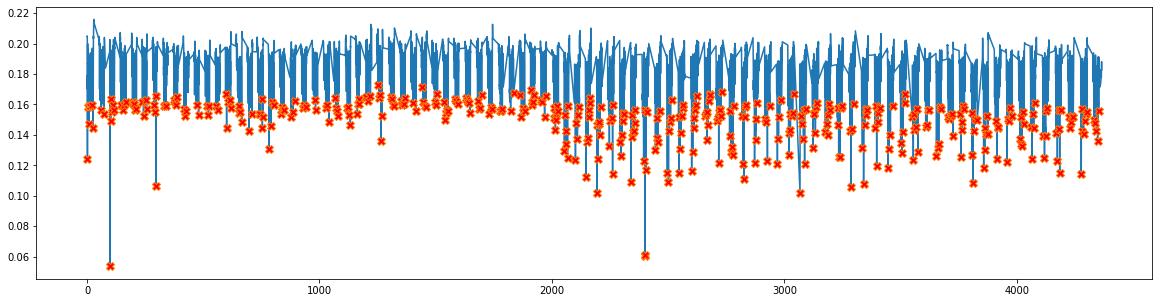

[2.146368980407715, 4.564570426940918, 2.080484628677368, 1.764986515045166, 9.16649866104126, 4.58700156211853, 10.72734522819519, 11.131990909576416, 4.220958471298218, 2.3019862174987793, 1.7603809833526611, 2.193115472793579, 7.725216388702393, 4.469168424606323, 7.240697622299194, 7.80241322517395, 4.042574405670166, 9.131158113479614, 4.78601336479187, 4.076096534729004, 4.0869996547698975, 3.778470039367676, 3.93703556060791, 6.111785173416138, 4.1898674964904785, 6.9750213623046875, 4.063887596130371, 10.230917692184448, 4.128296852111816, 4.204202175140381, 1.7299737930297852, 11.694065570831299, 4.190118074417114, 3.749833822250366, 12.571069717407227, 4.51196813583374, 4.71761679649353, 4.498536825180054, 7.108673572540283, 4.584642648696899, 3.8361001014709473, 26.954647302627563, 4.334917306900024, 12.824491739273071, 5.273331165313721, 3.8722217082977295, 4.843867778778076, 8.37000060081482, 13.417760848999023, 4.335408449172974, 4.153144836425781, 7.475983142852783, 4.07

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


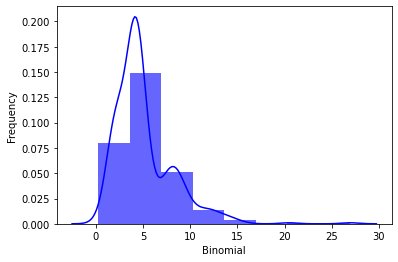

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


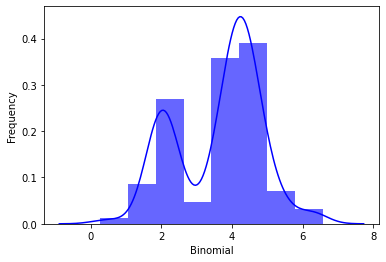

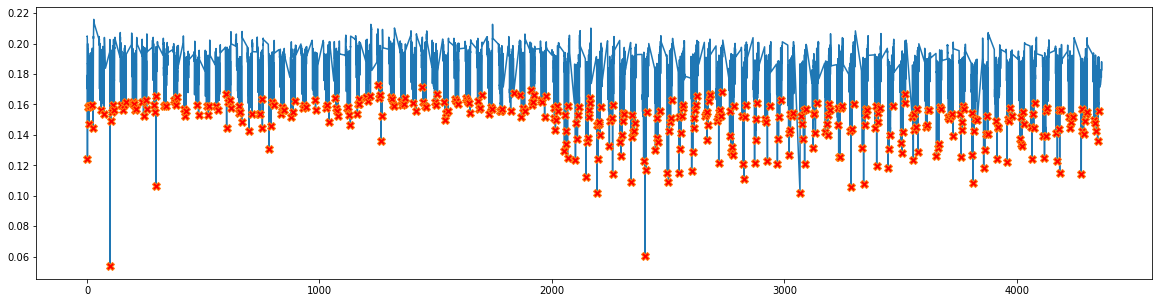

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


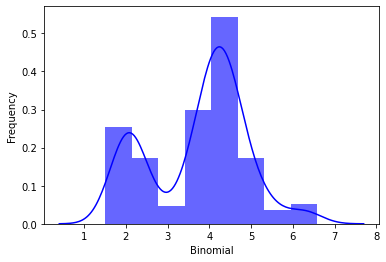

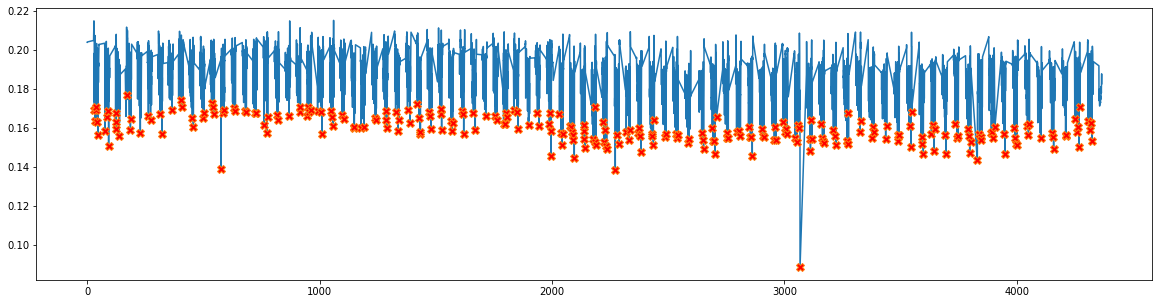

[2.3371732234954834, 4.030550956726074, 2.266510248184204, 4.309459209442139, 4.102999687194824, 6.513030052185059, 7.841516494750977, 3.6629409790039062, 3.300137519836426, 6.368554592132568, 1.7483301162719727, 1.9840357303619385, 12.778285264968872, 6.275934934616089, 16.85710310935974, 2.065585136413574, 18.957245111465454, 10.048124074935913, 10.46364974975586, 19.1332848072052, 6.566186428070068, 25.05311346054077, 14.679616689682007, 4.272252798080444, 22.517910480499268, 3.929722547531128, 17.83856225013733, 4.251179933547974, 9.363914966583252, 8.34232759475708, 3.5178935527801514, 4.742872953414917, 7.336493253707886, 4.422098398208618, 17.461112022399902, 8.98106050491333, 16.14553689956665, 4.3142852783203125, 13.089070081710815, 4.595043420791626, 8.412739038467407, 10.812012195587158, 4.249017953872681, 13.603275060653687, 3.875798463821411, 23.61312460899353, 21.723828077316284, 4.33143162727356, 5.2722485065460205, 2.0042831897735596, 3.835625410079956, 10.7378587722778

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


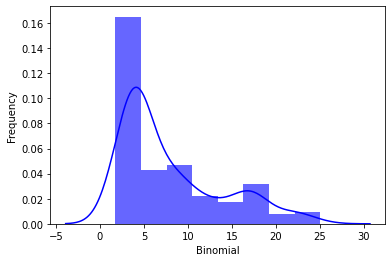

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


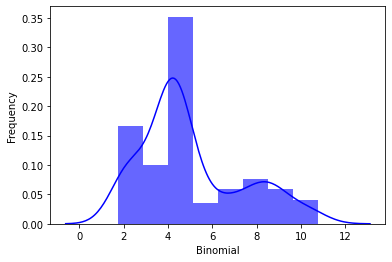

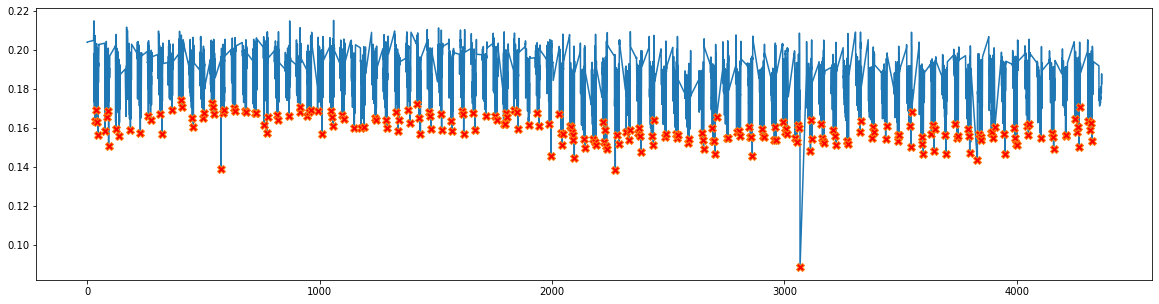

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


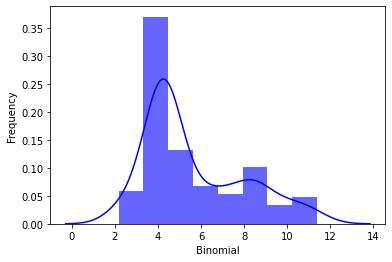

In [11]:
_,plus_peaks_R=extract_strike_times(df_plus,Time_to_index_ratio)
_,minus_peaks_R=extract_strike_times(df_minus,Time_to_index_ratio)

# sampling- right leg

In [12]:
sample_strikes_plus_R,sample_strikes_minus_R,avg_stride_plus_R,avg_stride_minus_R=sample_and_avg(df_plus,df_minus,plus_peaks_R,minus_peaks_R,time_return_points)


strides
[[], [12.783415794372559], [], [2.2196335792541504, 4.059805393218994, 7.756988286972046, 3.865572214126587], [], [8.021842002868652, 4.196612358093262, 8.514501333236694], [], [4.125753164291382, 4.214479923248291, 4.193495273590088, 3.8501269817352295], [], [4.666533946990967, 8.449750661849976, 4.566398620605469], [], [4.287328481674194, 4.334665060043335, 1.735156536102295], [], [4.241530656814575, 4.350687742233276], [], [4.31250262260437, 4.392252445220947, 4.339838266372681], [], [4.412867307662964, 4.231973171234131], [], [4.642552614212036], [], [5.941812992095947, 4.18634033203125], [], [8.078838348388672], [], [4.418685674667358, 4.2174060344696045, 8.466211080551147, 4.2835938930511475], [], [1.9930930137634277, 1.7583868503570557, 8.716700553894043], [], [12.072175741195679], [], [4.134221076965332, 8.280321598052979, 2.7031733989715576], [], [8.98190712928772, 3.851188898086548, 8.365138292312622], [], [4.390273332595825, 4.238473892211914, 4.005569696426392], [],

/home/jayasanka/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jayasanka/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Left leg

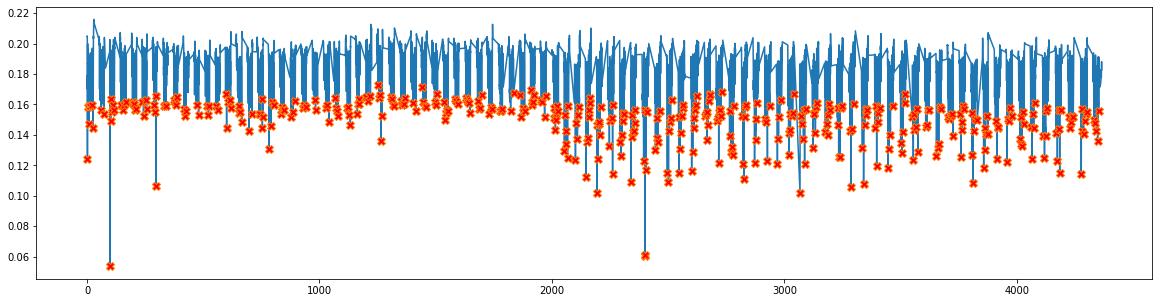

[2.146368980407715, 4.564570426940918, 2.080484628677368, 1.764986515045166, 9.16649866104126, 4.58700156211853, 10.72734522819519, 11.131990909576416, 4.220958471298218, 2.3019862174987793, 1.7603809833526611, 2.193115472793579, 7.725216388702393, 4.469168424606323, 7.240697622299194, 7.80241322517395, 4.042574405670166, 9.131158113479614, 4.78601336479187, 4.076096534729004, 4.0869996547698975, 3.778470039367676, 3.93703556060791, 6.111785173416138, 4.1898674964904785, 6.9750213623046875, 4.063887596130371, 10.230917692184448, 4.128296852111816, 4.204202175140381, 1.7299737930297852, 11.694065570831299, 4.190118074417114, 3.749833822250366, 12.571069717407227, 4.51196813583374, 4.71761679649353, 4.498536825180054, 7.108673572540283, 4.584642648696899, 3.8361001014709473, 26.954647302627563, 4.334917306900024, 12.824491739273071, 5.273331165313721, 3.8722217082977295, 4.843867778778076, 8.37000060081482, 13.417760848999023, 4.335408449172974, 4.153144836425781, 7.475983142852783, 4.07

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


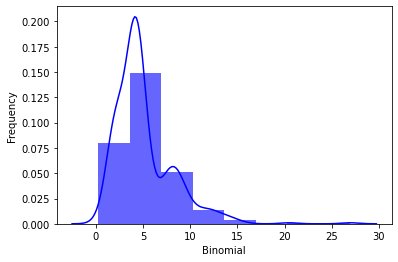

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


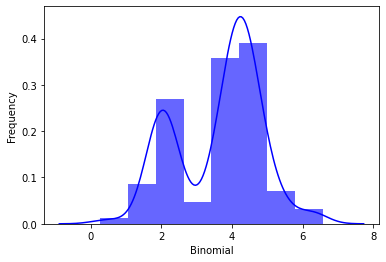

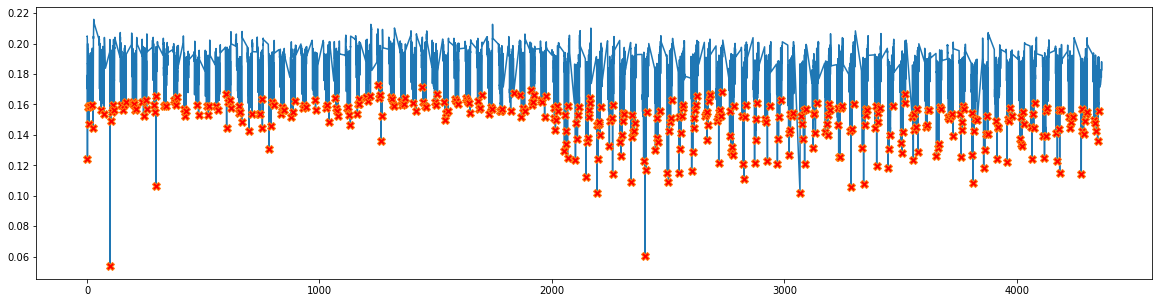

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


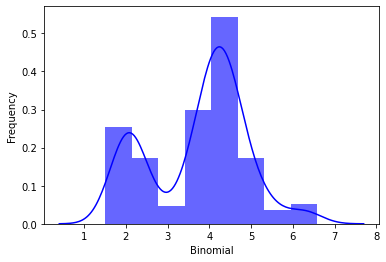

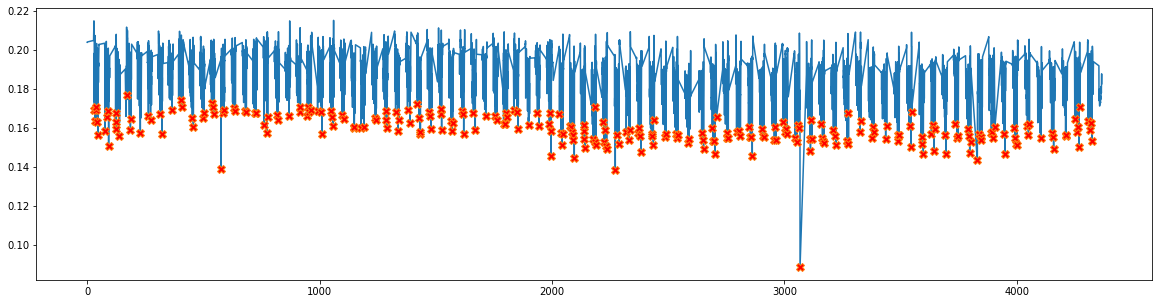

[2.3371732234954834, 4.030550956726074, 2.266510248184204, 4.309459209442139, 4.102999687194824, 6.513030052185059, 7.841516494750977, 3.6629409790039062, 3.300137519836426, 6.368554592132568, 1.7483301162719727, 1.9840357303619385, 12.778285264968872, 6.275934934616089, 16.85710310935974, 2.065585136413574, 18.957245111465454, 10.048124074935913, 10.46364974975586, 19.1332848072052, 6.566186428070068, 25.05311346054077, 14.679616689682007, 4.272252798080444, 22.517910480499268, 3.929722547531128, 17.83856225013733, 4.251179933547974, 9.363914966583252, 8.34232759475708, 3.5178935527801514, 4.742872953414917, 7.336493253707886, 4.422098398208618, 17.461112022399902, 8.98106050491333, 16.14553689956665, 4.3142852783203125, 13.089070081710815, 4.595043420791626, 8.412739038467407, 10.812012195587158, 4.249017953872681, 13.603275060653687, 3.875798463821411, 23.61312460899353, 21.723828077316284, 4.33143162727356, 5.2722485065460205, 2.0042831897735596, 3.835625410079956, 10.7378587722778

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


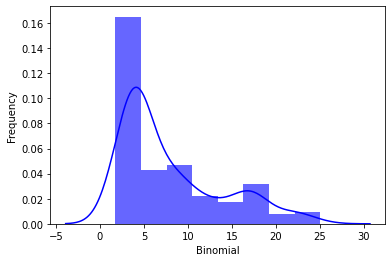

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


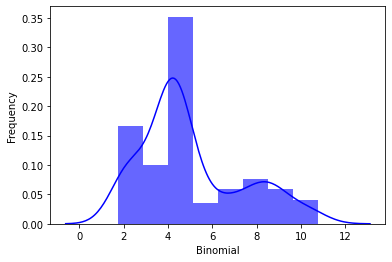

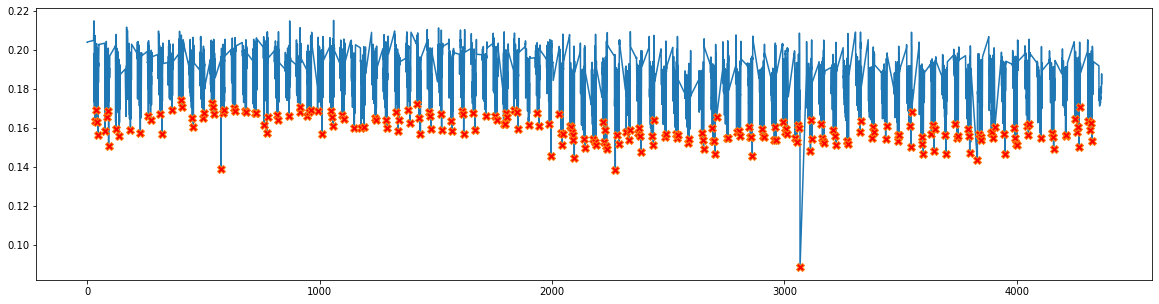

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


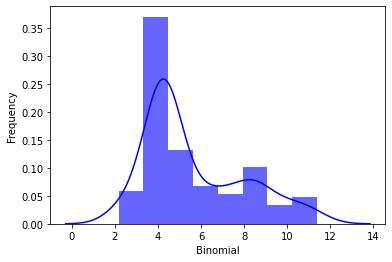

In [13]:
_,plus_peaks_L=extract_strike_times(df_plus,Time_to_index_ratio)
_,minus_peaks_L=extract_strike_times(df_minus,Time_to_index_ratio)

In [14]:
sample_strikes_plus_L,sample_strikes_minus_L,avg_stride_plus_L,avg_stride_minus_L=sample_and_avg(df_plus,df_minus,plus_peaks_L,minus_peaks_L,time_return_points)

strides
[[], [12.783415794372559], [], [2.2196335792541504, 4.059805393218994, 7.756988286972046, 3.865572214126587], [], [8.021842002868652, 4.196612358093262, 8.514501333236694], [], [4.125753164291382, 4.214479923248291, 4.193495273590088, 3.8501269817352295], [], [4.666533946990967, 8.449750661849976, 4.566398620605469], [], [4.287328481674194, 4.334665060043335, 1.735156536102295], [], [4.241530656814575, 4.350687742233276], [], [4.31250262260437, 4.392252445220947, 4.339838266372681], [], [4.412867307662964, 4.231973171234131], [], [4.642552614212036], [], [5.941812992095947, 4.18634033203125], [], [8.078838348388672], [], [4.418685674667358, 4.2174060344696045, 8.466211080551147, 4.2835938930511475], [], [1.9930930137634277, 1.7583868503570557, 8.716700553894043], [], [12.072175741195679], [], [4.134221076965332, 8.280321598052979, 2.7031733989715576], [], [8.98190712928772, 3.851188898086548, 8.365138292312622], [], [4.390273332595825, 4.238473892211914, 4.005569696426392], [],

/home/jayasanka/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jayasanka/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# define feature vector array

In [15]:
TP_side=[]

T_s=[[[None],[None]],[[None],[None]],[[None],[None]],[[None],[None]],[None],[None],[None],[None]]

# stride time 

T3=comb_dir_arrays(avg_stride_plus_R,avg_stride_minus_R,plus,minus)

T4=comb_dir_arrays(avg_stride_plus_L,avg_stride_minus_L,plus,minus)

T_s[1][0]=T3
T_s[1][1]=T4

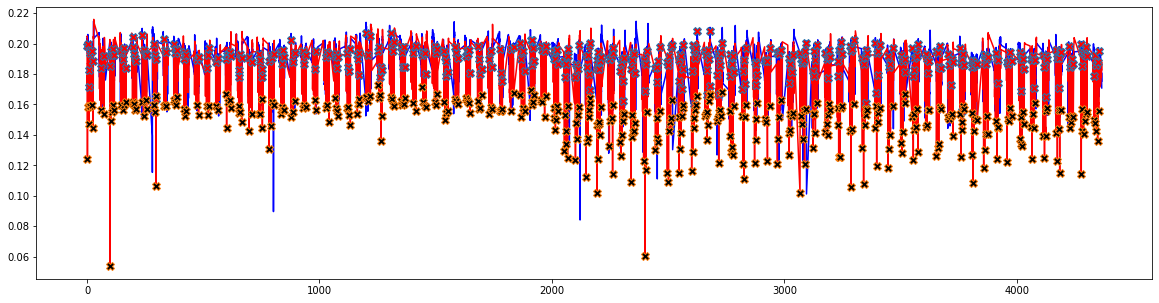

[[], [59.987924337387085, 72.77134013175964], [], [99.55724859237671, 101.77688217163086, 105.83668756484985, 113.5936758518219, 117.45924806594849], [], [146.3655400276184, 154.38738203048706, 158.58399438858032, 167.09849572181702], [], [195.79320454597473, 199.9189577102661, 204.1334376335144, 208.3269329071045, 212.17705988883972], [], [238.48516154289246, 243.15169548988342, 251.6014461517334, 256.16784477233887], [], [288.245414018631, 292.5327425003052, 296.8674075603485, 298.6025640964508], [], [331.5775797367096, 335.81911039352417, 340.16979813575745], [], [375.8058326244354, 380.1183352470398, 384.51058769226074, 388.8504259586334], [], [417.25353145599365, 421.6663987636566, 425.89837193489075], [], [475.20143151283264, 479.8439841270447], [], [516.224002122879, 522.165815114975, 526.3521554470062], [], [553.7165236473083, 561.795361995697], [], [596.0828745365143, 600.5015602111816, 604.7189662456512, 613.1851773262024, 617.4687712192535], [], [652.7827897071838, 654.77588

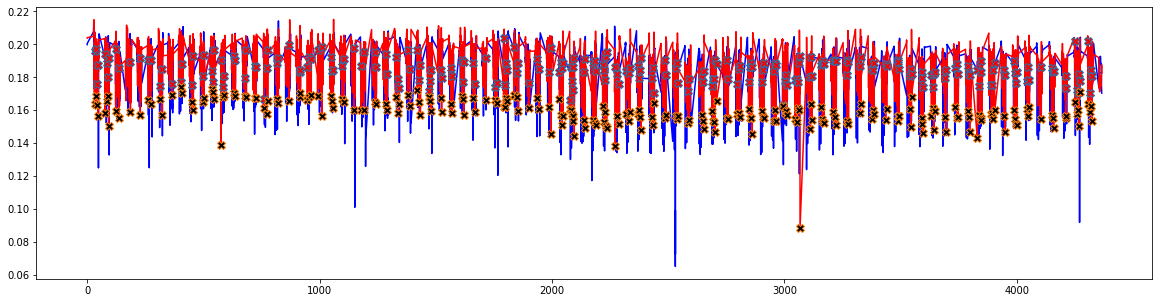

[[33.891178369522095, 37.4362108707428, 42.83907890319824, 46.70022106170654], [], [76.9470865726471, 84.72258472442627, 88.82660031318665, 92.63137435913086], [], [124.69111776351929, 137.7293725013733], [], [186.4201056957245], [], [229.04586219787598], [], [263.73073291778564, 272.9218039512634], [], [315.63786721229553, 321.4781608581543], [], [365.74657583236694], [], [403.81974959373474, 407.2833435535431], [], [452.70683884620667, 457.1383156776428], [], [498.74813961982727, 502.9558193683624], [], [535.3848931789398, 543.2254340648651, 547.1252639293671], [], [575.695029258728, 583.4751582145691, 587.0239098072052], [], [630.1135458946228, 637.9017841815948], [], [681.2003738880157, 685.0541429519653], [], [721.8298079967499, 725.922441482544], [], [760.9082305431366, 772.8140435218811, 776.8172776699066], [], [816.0632901191711, 820.4336740970612], [], [868.6129240989685], [], [913.8354687690735, 917.7475366592407], [], [947.4651005268097, 953.856794834137, 964.2054409980774],

/tmp/ipykernel_33002/2705242555.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  avg_step_plus_L=list(map(lambda a : np.mean(a) if a!=['ooa'] else ['ooa'], step_plus_L))
/tmp/ipykernel_33002/2705242555.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  avg_step_minus_L=list(map(lambda a : np.mean(a) if a!=['ooa'] else ['ooa'], step_minus_L))
/tmp/ipykernel_33002/2705242555.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  avg_step_plus_R=list(map(lambda a : np.mean(a) if a!=['ooa'] else ['ooa'], step_plus_R))
/tmp/ipykernel_33002/2705242555.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  avg_step_minus_R=list(map(lambda a : np.mean(a) if a!=['ooa'] el

In [16]:
#plus direction

step_plus_R,step_plus_L=extract_steps(sample_strikes_plus_L,sample_strikes_plus_R,plus_peaks_R,plus_peaks_L,df_plus)

#minus direction

step_minus_R,step_minus_L=extract_steps(sample_strikes_minus_L,sample_strikes_minus_R,minus_peaks_R,minus_peaks_L,df_minus)

avg_step_plus_L=list(map(lambda a : np.mean(a) if a!=['ooa'] else ['ooa'], step_plus_L))
avg_step_minus_L=list(map(lambda a : np.mean(a) if a!=['ooa'] else ['ooa'], step_minus_L))
avg_step_plus_R=list(map(lambda a : np.mean(a) if a!=['ooa'] else ['ooa'], step_plus_R))
avg_step_minus_R=list(map(lambda a : np.mean(a) if a!=['ooa'] else ['ooa'], step_minus_R))

T1=comb_dir_arrays(avg_step_plus_R,avg_step_minus_R,plus,minus)
T2=comb_dir_arrays(avg_step_plus_L,avg_step_minus_L,plus,minus)

T_s[0][0]=T1
T_s[0][1]=T2

# find heel strike and toe-off time-Right

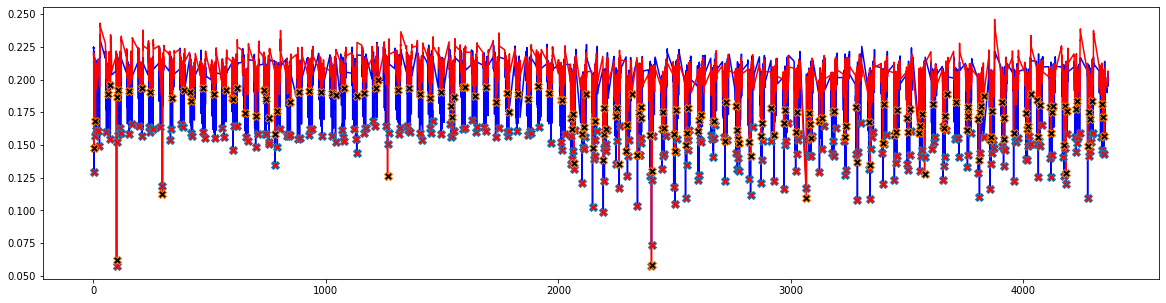

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


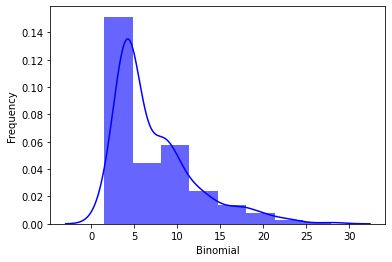

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


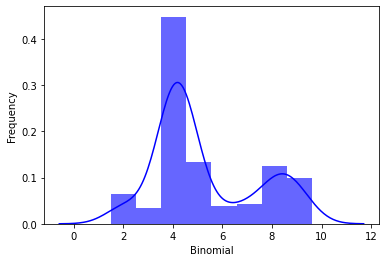

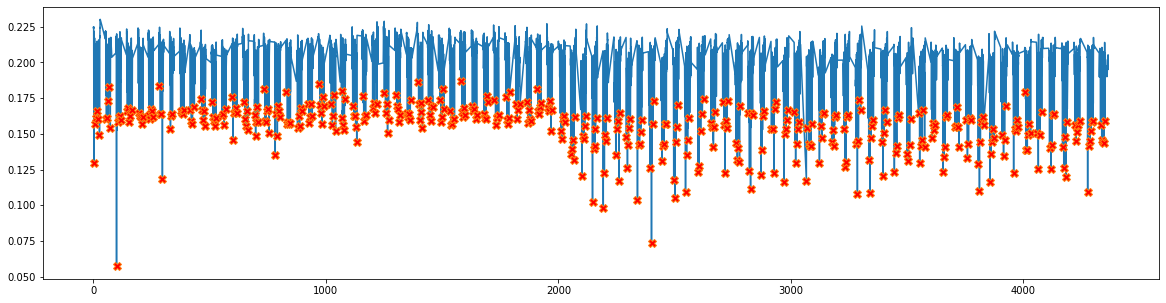

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


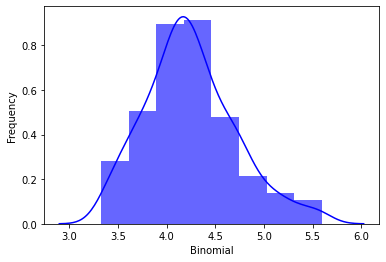

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


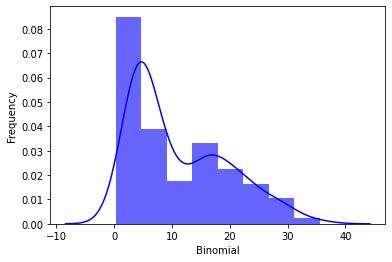

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


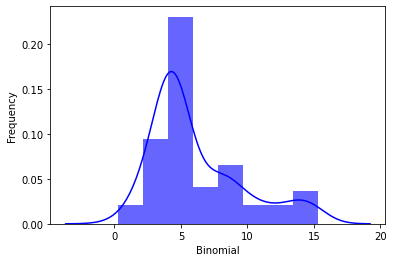

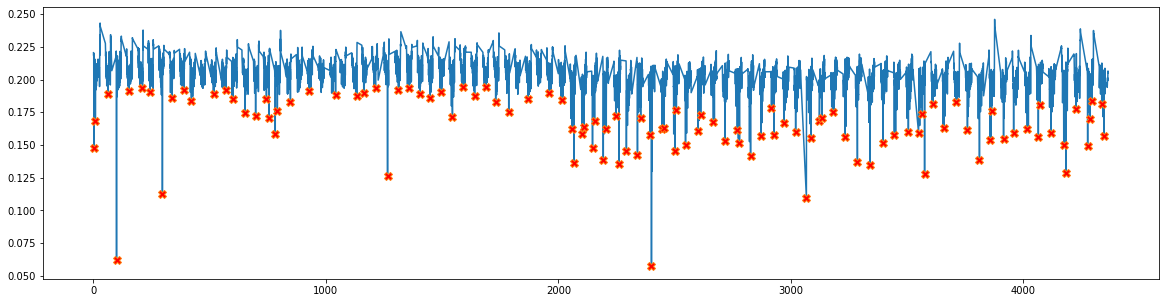

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


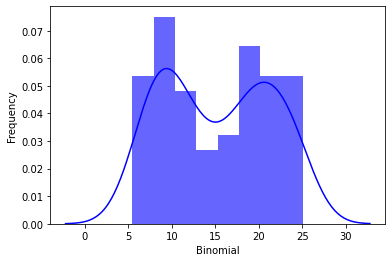

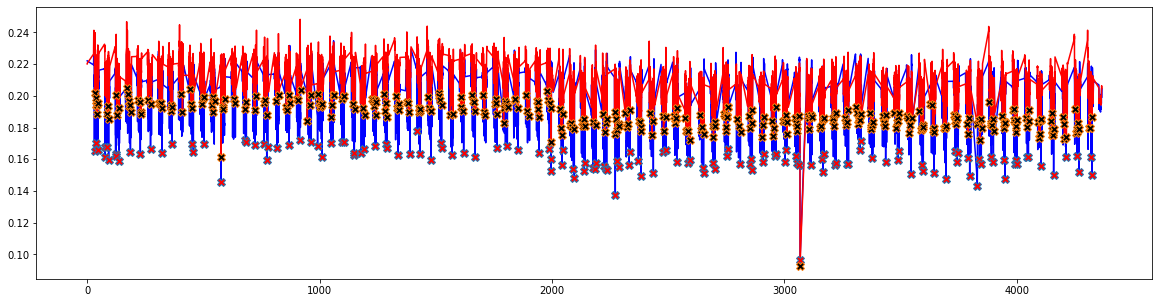

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


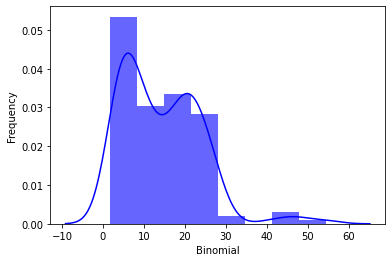

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


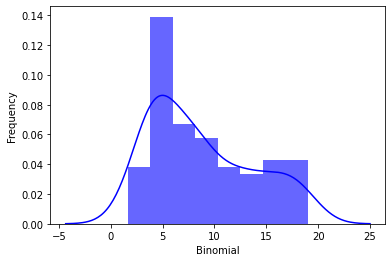

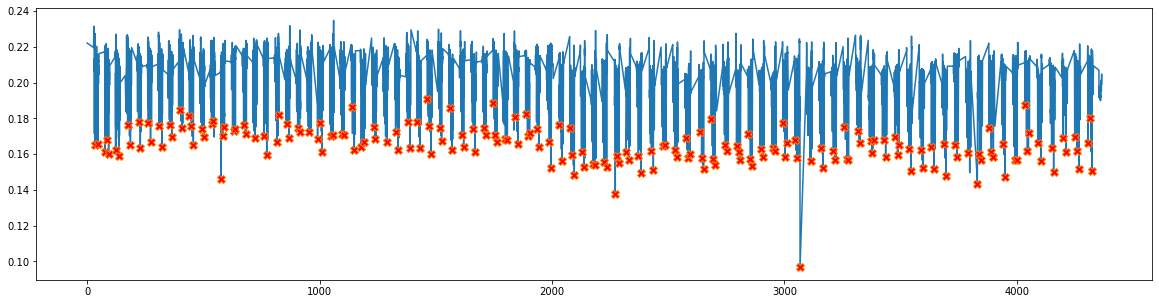

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


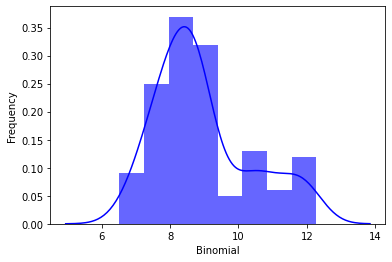

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


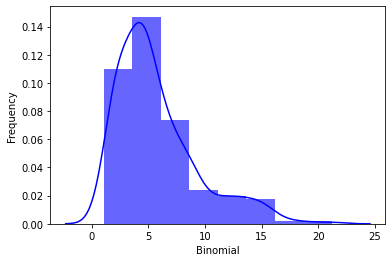

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


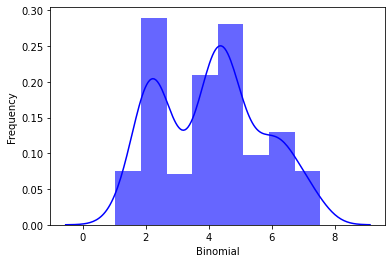

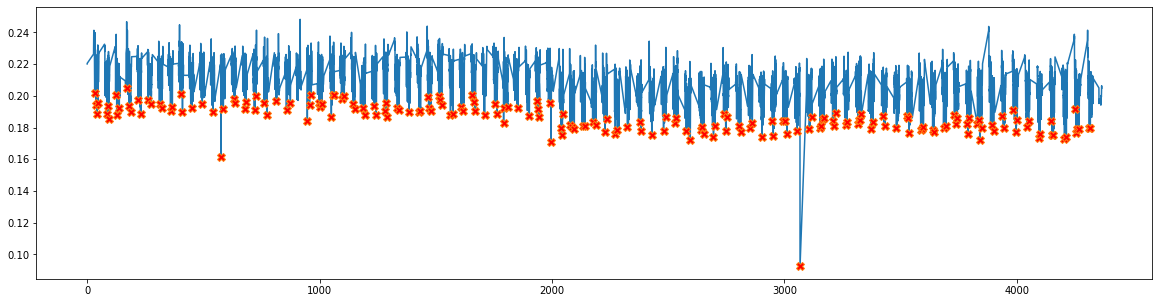

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


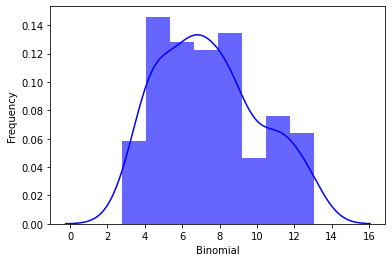

In [17]:
# plus direction-Right

h_valley_plus_R, _ = find_peaks(-df_plus.h_R,prominence=0.05)
f_valley_plus_R, _ = find_peaks(-df_plus.f_R,prominence=0.025)
plt.figure(figsize=(20,5))
plt.plot(df_plus.t,df_plus.h_R,'b')
plt.plot(df_plus.t,df_plus.f_R,'r')
plt.plot(df_plus.t[h_valley_plus_R], df_plus.h_R[h_valley_plus_R],"X",markerfacecolor='red',markersize=8)
plt.plot(df_plus.t[f_valley_plus_R], df_plus.f_R[f_valley_plus_R],"X",markerfacecolor='black',markersize=8)
plt.show()


dt_plus_to_r_cleaned,dt_plus_hs_r_cleaned,plus_peaks_to_r,plus_peaks_hs_r=outlier_remove(h_valley_plus_R,f_valley_plus_R,df_plus)

#minus direction -Right

h_valley_minus_R, _ = find_peaks(-df_minus.h_R,prominence=0.05)
f_valley_minus_R, _ = find_peaks(-df_minus.f_R,prominence=0.025)
plt.figure(figsize=(20,5))
plt.plot(df_minus.t,df_minus.h_R,'b')
plt.plot(df_minus.t,df_minus.f_R,'r')
plt.plot(df_minus.t[h_valley_minus_R], df_minus.h_R[h_valley_minus_R],"X",markerfacecolor='red',markersize=8)
plt.plot(df_minus.t[f_valley_minus_R], df_minus.f_R[f_valley_minus_R],"X",markerfacecolor='black',markersize=8)
plt.show()

dt_minus_to_r_cleaned,dt_minus_hs_r_cleaned,minus_peaks_to_r,minus_peaks_hs_r=outlier_remove(h_valley_minus_R,f_valley_minus_R,df_minus)

# sampling-Right

sample_strikes_plus_hs_R=sample(df_plus,plus_peaks_hs_r,time_return_points)
sample_strikes_minus_hs_R=sample(df_minus,minus_peaks_hs_r,time_return_points)
sample_strikes_plus_to_R=sample(df_plus,plus_peaks_to_r,time_return_points)
sample_strikes_minus_to_R=sample(df_minus,minus_peaks_to_r,time_return_points)

# find heel strike and toe-off time-left

# Plus direction-left

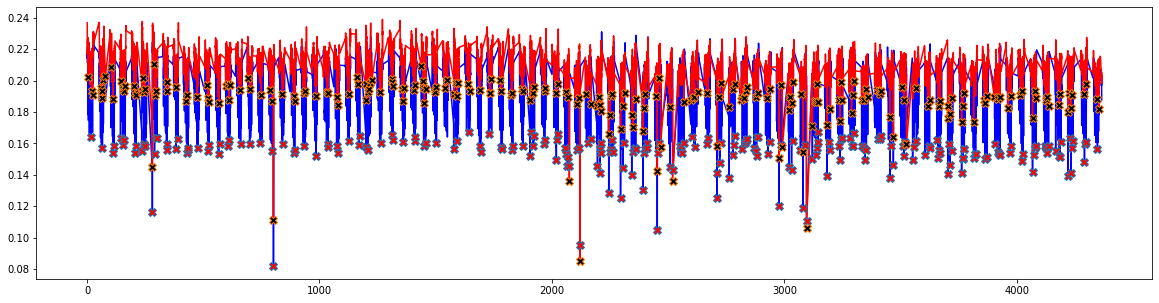

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


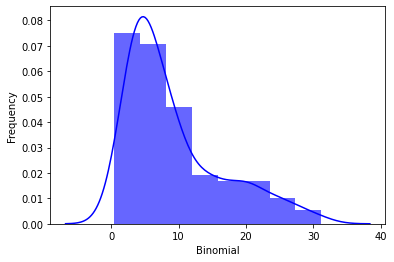

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


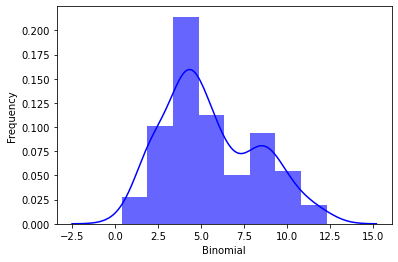

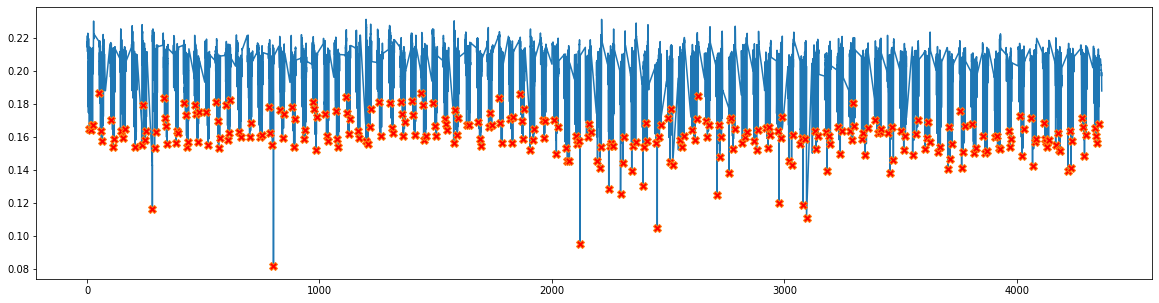

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


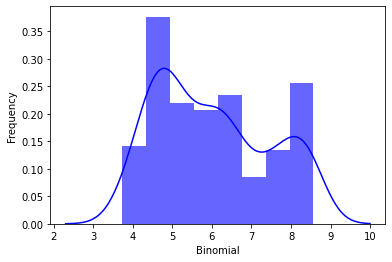

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


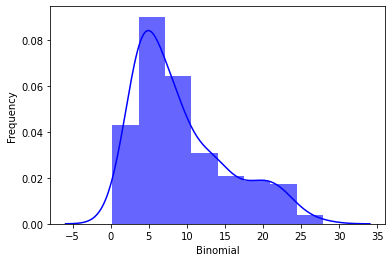

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


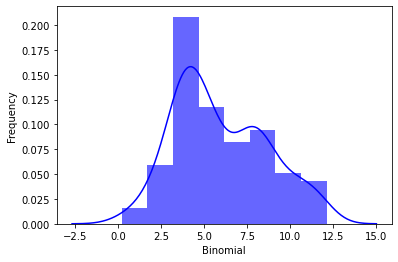

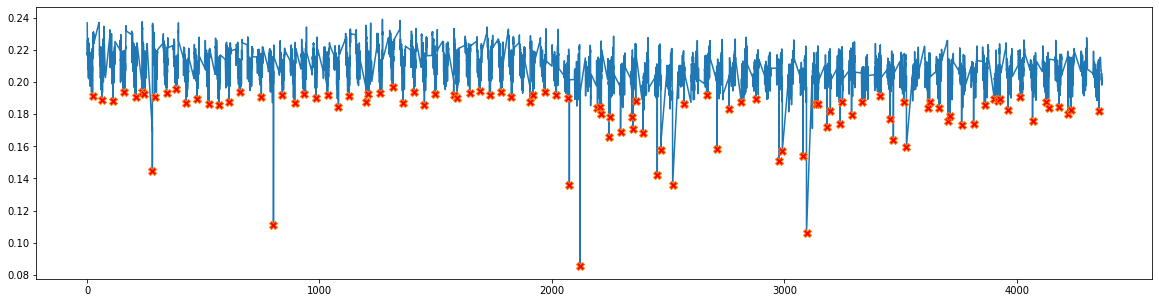

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


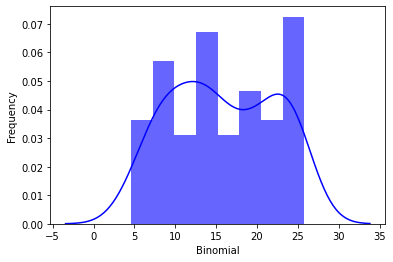

In [18]:
h_valley_plus_L, _ = find_peaks(-df_plus.h_L,prominence=0.05)
f_valley_plus_L, _ = find_peaks(-df_plus.f_L,prominence=0.02)
plt.figure(figsize=(20,5))
plt.plot(df_plus.t,df_plus.h_L,'b')
plt.plot(df_plus.t,df_plus.f_L,'r')
plt.plot(df_plus.t[h_valley_plus_L], df_plus.h_L[h_valley_plus_L],"X",markerfacecolor='red',markersize=8)
plt.plot(df_plus.t[f_valley_plus_L], df_plus.f_L[f_valley_plus_L],"X",markerfacecolor='black',markersize=8)
plt.show()


#toe off
dt_plus_to_l=time_diff(h_valley_plus_L)
distribution(dt_plus_to_l)
dt_plus_to_l_new=remove_time_gap(dt_plus_to_l)
distribution(dt_plus_to_l_new)
plus_peaks_to_l=remove_distinc(dt_plus_to_l,df_plus,Time_to_index_ratio,df_plus.h_L)
dt_plus_to_l=time_diff(plus_peaks_to_l)
dt_plus_to_l_cleaned=remove_time_gap(dt_plus_to_l)
distribution(dt_plus_to_l_cleaned)

#heel strike
dt_plus_hs_l=time_diff(f_valley_plus_L)
distribution(dt_plus_hs_l)
dt_plus_hs_l_new=remove_time_gap(dt_plus_hs_l)
distribution(dt_plus_hs_l_new)
plus_peaks_hs_l=remove_distinc(dt_plus_hs_l,df_plus,Time_to_index_ratio,df_plus.f_L)
dt_plus_hs_l=time_diff(plus_peaks_hs_l)
dt_plus_hs_l_cleaned=remove_time_gap(dt_plus_hs_l)
distribution(dt_plus_hs_l_cleaned)

# minus-direction-left

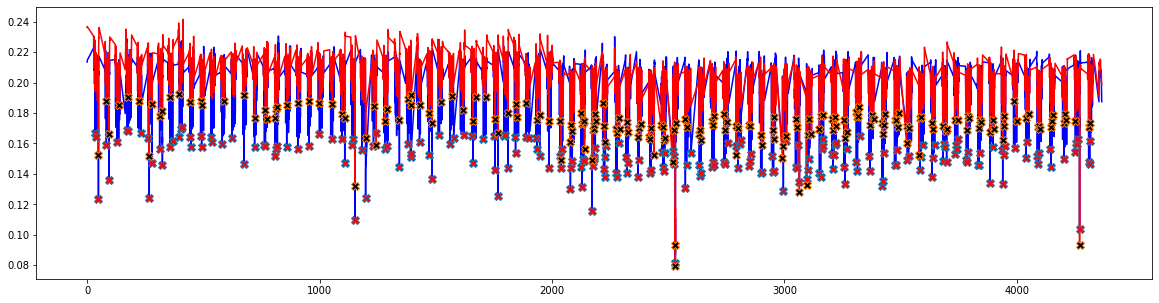

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


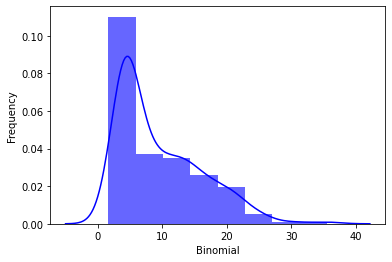

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


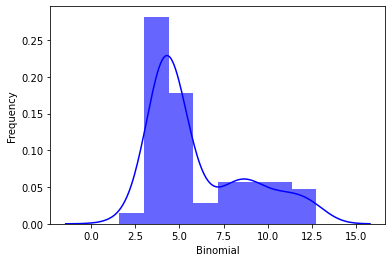

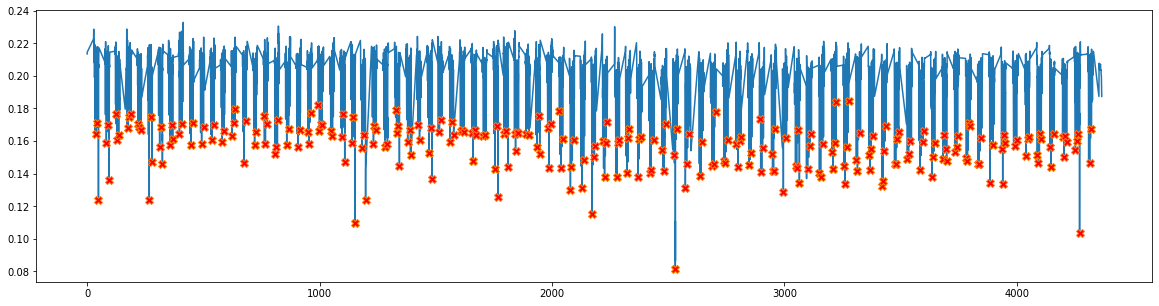

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


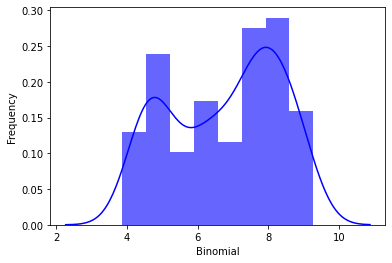

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


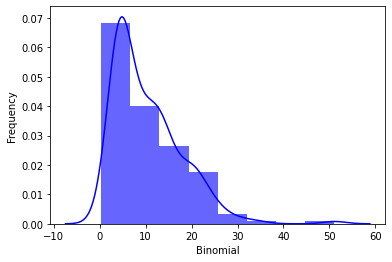

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


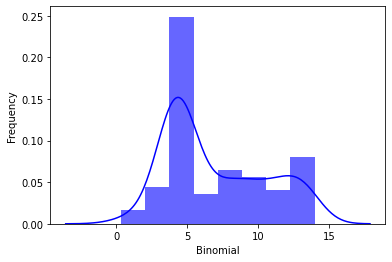

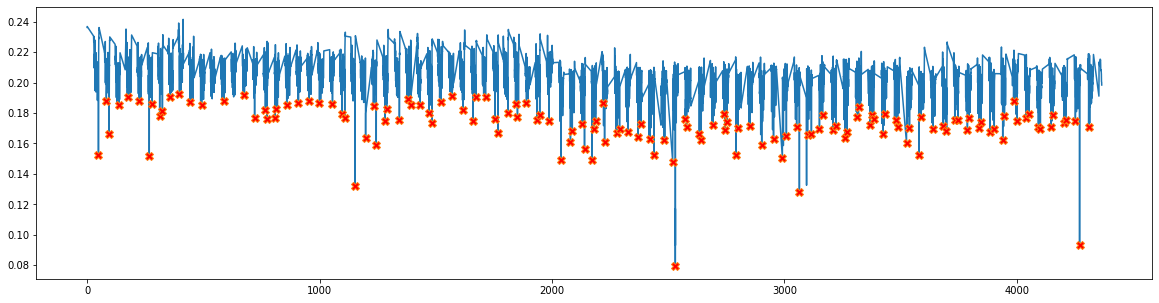

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


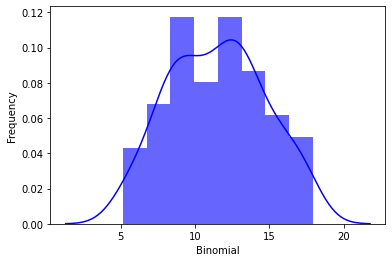

In [19]:
h_valley_minus_L, _ = find_peaks(-df_minus.h_L,prominence=0.05)
f_valley_minus_L, _ = find_peaks(-df_minus.f_L,prominence=0.03)
plt.figure(figsize=(20,5))
plt.plot(df_minus.t,df_minus.h_L,'b')
plt.plot(df_minus.t,df_minus.f_L,'r')
plt.plot(df_minus.t[h_valley_minus_L], df_minus.h_L[h_valley_minus_L],"X",markerfacecolor='red',markersize=8)
plt.plot(df_minus.t[f_valley_minus_L], df_minus.f_L[f_valley_minus_L],"X",markerfacecolor='black',markersize=8)
plt.show()

#toe off
dt_minus_to_l=time_diff(h_valley_minus_L)
distribution(dt_minus_to_l)
dt_minus_to_l_new=remove_time_gap(dt_minus_to_l)
distribution(dt_minus_to_l_new)
minus_peaks_to_l=remove_distinc(dt_minus_to_l,df_minus,Time_to_index_ratio,df_minus.h_L)
dt_minus_to_l=time_diff(minus_peaks_to_l)
dt_minus_to_l_cleaned=remove_time_gap(dt_minus_to_l)
distribution(dt_minus_to_l_cleaned)


#heel strike
dt_minus_hs_l=time_diff(f_valley_minus_L)
distribution(dt_minus_hs_l)
dt_minus_hs_l_new=remove_time_gap(dt_minus_hs_l)
distribution(dt_minus_hs_l_new)
minus_peaks_hs_l=remove_distinc(dt_minus_hs_l,df_minus,Time_to_index_ratio,df_minus.f_L)
dt_minus_hs_l=time_diff(minus_peaks_hs_l)
dt_minus_hs_l_cleaned=remove_time_gap(dt_minus_hs_l)
distribution(dt_minus_hs_l_cleaned)

# sampling-left

In [20]:
sample_strikes_plus_hs_L=sample(df_plus,plus_peaks_hs_l,time_return_points)
sample_strikes_minus_hs_L=sample(df_minus,minus_peaks_hs_l,time_return_points)
sample_strikes_plus_to_L=sample(df_plus,plus_peaks_to_l,time_return_points)
sample_strikes_minus_to_L=sample(df_minus,minus_peaks_to_l,time_return_points)
sample_strikes_plus_hs_L=sample_strikes_plus_hs_L[plus::2]
sample_strikes_plus_to_L=sample_strikes_plus_to_L[plus::2]
sample_strikes_minus_hs_L=sample_strikes_minus_hs_L[minus::2]
sample_strikes_minus_to_L=sample_strikes_minus_to_L[minus::2]

In [21]:
time_diff_array([2,5,8],[3,7,10])

(array([2, 1]), array([1, 2, 2]))

# Calculate swing time

In [22]:
swing_array_plus_R=swing_array(sample_strikes_plus_hs_R,sample_strikes_plus_to_R)
print(swing_array_plus_R)

swing_array_plus_L=swing_array(sample_strikes_plus_hs_L,sample_strikes_plus_to_L)
print(swing_array_plus_L)

swing_array_minus_R=swing_array(sample_strikes_minus_hs_R,sample_strikes_minus_to_R)
swing_array_minus_L=swing_array(sample_strikes_minus_hs_L,sample_strikes_minus_to_L)

avg_swing_plus_R=avrg(swing_array_plus_R)
avg_swing_plus_L=avrg(swing_array_plus_L)
avg_swing_minus_R=avrg(swing_array_minus_R)
avg_swing_minus_L=avrg(swing_array_minus_L)

T7=comb_dir_arrays(avg_swing_plus_R,avg_swing_minus_R,plus,minus)
T8=comb_dir_arrays(avg_swing_plus_L,avg_swing_minus_L,plus,minus)

T_s[3][0]=T7
T_s[3][1]=T8

[['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], array([0.]), ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa'], ['ooa']]
[array([0.]), ['ooa'], ['ooa'], array([0.]), ['ooa']]


/tmp/ipykernel_33002/68051803.py:199: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if i==['ooa']:


# calculate double support time

In [23]:
double_support_time(sample_strikes_plus_to_R,sample_strikes_plus_hs_R,sample_strikes_plus_to_L,sample_strikes_plus_hs_L)

'ooa'

# calculate stance time ratio

In [24]:

T_plus=np.add(avg_stride_plus_L,avg_stride_plus_R)/2
T_minus=np.add(avg_stride_minus_L,avg_stride_minus_R)/2

STR_plus=stance_time_ratio_array(sample_strikes_plus_to_R,sample_strikes_plus_hs_R,sample_strikes_plus_to_L,sample_strikes_plus_hs_L,T_plus)
STR_minus=stance_time_ratio_array(sample_strikes_minus_to_R,sample_strikes_minus_hs_R,sample_strikes_minus_to_L,sample_strikes_minus_hs_L,T_minus)
print(STR_plus)
print(STR_minus)

[['ooa']]
[]


# calculate swing time ratio

In [25]:
swing_time_ratio_array(sample_strikes_plus_to_R,sample_strikes_plus_hs_R,sample_strikes_plus_to_L,sample_strikes_plus_hs_L,T_plus)
swing_time_ratio_array(sample_strikes_plus_to_R,sample_strikes_plus_hs_R,sample_strikes_plus_to_L,sample_strikes_plus_hs_L,T_minus)

/tmp/ipykernel_33002/68051803.py:264: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if left==['ooa'] or right==['ooa']:


[['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa'],
 ['ooa']]

# .....................................................................................

In [28]:
output = open('para_values/left/Time/{}.pkl'.format(name), 'wb')
pickle.dump(T_s, output)
output.close()

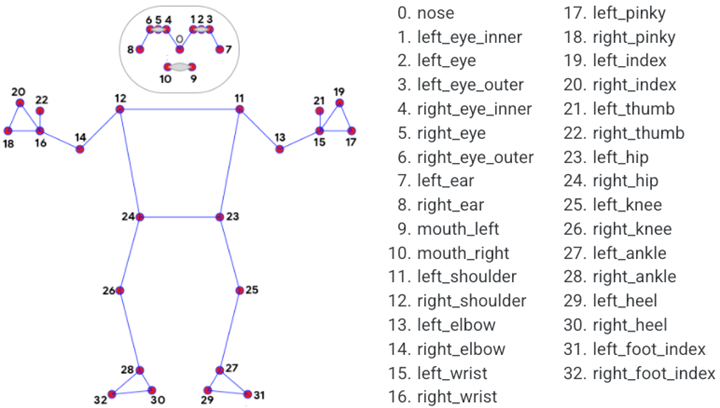